# <center>**Steam 플렛폼 구매율 예측 (linear regression)**</center>

<img src = "http://images.vg247.com/current//2011/04/steam1.jpg">

# <center> **개요** </center>

## **목표**
스팀 플렛폼(게임)에 관련된 데이터로 <span style="color:red">구매율(어플리케이션 소유자 수)</span>를 예측하는 모델을 생성<br>
<br>

## **변수정의**

  * appid - 게임 고유 ID
  * name - 게임 이름 category
  * developer - 개발자(여러 개발자 일 경우 쉼표로 구분) category 
  * publisher - 발행자(유통사) category
  * score_rank - 사용자 리뷰를 기반으로 만들어진 게임의 점수 등급 category
  * positive - 긍정적인 사용자의 리뷰 수 real
  * negative - 부정적인 사용자의 리뷰 수 real
  * userscore - 게임 사용자들이 평가한 점수 real
  * <span style="color:red">owners - steam에서 해당 어플리케이션 소유자 수</span> 
  * owners_variance - 소유자 분산(변동,차이). (실제소유자 +/- 변동범위) 형태로 표기 real
  * players_forever - 2009년 3월 이후로 플레어 수 real
  * players_forever_variance - 전체 플레이어의 분산. (전체 플레이어 +/- 변동범위) 형태로 표기 real
  * players_2weeks - 지난 2 주 동안 플레이어들의 수 real
  * players_2weeks_variance - 지난 2 주 동안 플레이어의 수에 대한 분산 (플레이어 수 +/- 변동범위) 형태로 표기real
  * average_forever - 2009년 3월 이후 플레이 시간(평균). 분 단위. category
  * average_2weeks - 지난 2 주간 플레이 시간(평균). 분 단위. category
  * median_forever - 2009년 3월 이후 플레이 시간(중앙값). 분 단위. category
  * median_2weeks - 지난 2 주간 플레이 시간(중앙값). 분 단위. category
  * price - US가격. 센트 단위. real
  * ccu - 어제 최고 CCU(개별 앱이 요청된 경우에만 카운트) ** 어제 동시접속자수
  * tag_(tag name) - 해당 게임의 태그(Yes=1, No=0) category
  * genre_(genre name) - 해당 게임의 장르(Yes=1, No=0) category

## **데이터**
**Steamspy에서 크롤링한 16722개의 게임 데이터** <br>
<br>
Test 데이터 :<br>
    * 전체 데이터 중 무작위 선발된 2000개 데이터
Train 데이터 :<br>
    * 무작위 선발 2000개를 제외한 데이터데이터

In [36]:
import random
import pymysql
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.api as sm
import seaborn as sns 

## **1. 데이터로딩**
MySQL to Jupyter notebook

In [4]:
host_name = "127.0.0.1"
username = "root"
password = ""
database_name = "steam_test"

In [5]:
db = pymysql.connect(
    host = host_name,
    port=3306,
    user=username,
    passwd=password,
    db=database_name,
    charset='utf8'
)

In [32]:
# 변수명
c_name = """
SELECT COLUMN_NAME
FROM information_schema.columns 
WHERE 
    table_schema = 'steam_test' 
    AND 
    table_name = 'merge_steam';
"""
column_name = pd.read_sql(c_name, db)
# print(column_name)
# tag range 20 ~ 362
# genre range 363 ~ 387
tag_range = column_name[20:362]
genre_range = column_name[363:387]
# print(genre_range)
# print(tag_range)

tag_name = []
genre_name = []
for i in tag_range['COLUMN_NAME']:
    tag_name.append(i)
# print(genre_range)
for i in genre_range['COLUMN_NAME']:
    genre_name.append(i)

column_name

,COLUMN_NAME
0,appid
1,name
2,owners
3,owners_variance
4,negative
5,positive
6,score_rank
7,ccu
8,players_2weeks
9,players_forever_variance


In [23]:
# 마지막 row
last_row ="""
SELECT * FROM merge_steam ORDER BY appid DESC LIMIT 1
"""
sql_1 = pd.read_sql(last_row, db)
sql_1

,appid,name,owners,owners_variance,negative,positive,score_rank,ccu,players_2weeks,players_forever_variance,...,genre_Sports,genre_Early_Access,genre_Utilities,genre_Audio_Production,genre_Design_and_Illustration,genre_Web_Publishing,genre_Photo_Editing,genre_Education,genre_Software_Training,genre_Accounting
0,779310,Red and Yellow,1558,1243,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# 전체 데이터
train_select ="""
SELECT * FROM merge_steam;
"""
all_data = pd.read_sql(train_select, db)
all_data.describe()

,appid,owners,owners_variance,negative,positive,score_rank,ccu,players_2weeks,players_forever_variance,players_2weeks_variance,...,genre_Sports,genre_Early_Access,genre_Utilities,genre_Audio_Production,genre_Design_and_Illustration,genre_Web_Publishing,genre_Photo_Editing,genre_Education,genre_Software_Training,genre_Accounting
count,16722.000000,1.672200e+04,16722.000000,16722.000000,1.672200e+04,16722.000000,1.672200e+04,1.672200e+04,16722.000000,16722.000000,...,16722.0,16722.0,16722.0,16722.0,16722.0,16722.0,16722.0,16722.0,16722.0,16722.0
mean,415098.262349,1.892723e+05,7757.778914,262.853068,1.331848e+03,37.351872,3.778284e+02,7.838098e+03,5888.402823,1152.652912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,185222.142966,1.317502e+06,11154.753854,3299.447117,1.984100e+04,31.439877,2.383492e+04,1.944500e+05,9346.944267,2605.644763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,10.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,303595.000000,3.634000e+03,1966.000000,3.000000,1.200000e+01,8.000000,0.000000e+00,0.000000e+00,1520.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,416235.000000,1.557600e+04,3933.000000,17.000000,4.800000e+01,31.000000,0.000000e+00,7.670000e+02,2734.000000,879.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,551912.500000,8.514800e+04,9196.000000,77.000000,2.447500e+02,61.000000,4.000000e+00,1.298000e+03,6659.000000,1523.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,779310.000000,1.204637e+08,301009.000000,245704.000000,2.162074e+06,100.000000,2.971824e+06,2.011675e+07,301009.000000,138470.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# appid 무작위 선출
random_sample2000 = list(all_data['appid'])

# 무작위 선발 2000개
ran_2000 = tuple(random.sample(random_sample2000, 2000))
print(ran_2000)

(7210, 560790, 562490, 578670, 704700, 358270, 360790, 329280, 610500, 682590, 546660, 244870, 215510, 423034, 227860, 340030, 649600, 294650, 501930, 272490, 15230, 374170, 549900, 11190, 652560, 493810, 458380, 545000, 482890, 444350, 301700, 355270, 512750, 691080, 504750, 496630, 503560, 538060, 376310, 562520, 559140, 448020, 587970, 491580, 272670, 538000, 438300, 625180, 403130, 272060, 311930, 508450, 348430, 759500, 560570, 372190, 593670, 63500, 597220, 405480, 303710, 431840, 555610, 517700, 410820, 392020, 331500, 289090, 701540, 431330, 534200, 372160, 8350, 585990, 684870, 368980, 217690, 314500, 304270, 583850, 650580, 722040, 404480, 372970, 358210, 767440, 594490, 61510, 446640, 353280, 318090, 453770, 33120, 546780, 553340, 465450, 38210, 58300, 577230, 253390, 355920, 680340, 369000, 506830, 455940, 648570, 548340, 264320, 753090, 561490, 456760, 312710, 585830, 343830, 347080, 745640, 21970, 562240, 356170, 259490, 437890, 521140, 652700, 269210, 548010, 299700, 390

In [6]:
# 무작위 선발 2000개
ran_2000 = (7210, 560790, 562490, 578670, 704700, 358270, 360790, 329280, 610500, 682590, 546660, 244870, 215510, 423034, 227860, 340030, 649600, 294650, 501930, 272490, 15230, 374170, 549900, 11190, 652560, 493810, 458380, 545000, 482890, 444350, 301700, 355270, 512750, 691080, 504750, 496630, 503560, 538060, 376310, 562520, 559140, 448020, 587970, 491580, 272670, 538000, 438300, 625180, 403130, 272060, 311930, 508450, 348430, 759500, 560570, 372190, 593670, 63500, 597220, 405480, 303710, 431840, 555610, 517700, 410820, 392020, 331500, 289090, 701540, 431330, 534200, 372160, 8350, 585990, 684870, 368980, 217690, 314500, 304270, 583850, 650580, 722040, 404480, 372970, 358210, 767440, 594490, 61510, 446640, 353280, 318090, 453770, 33120, 546780, 553340, 465450, 38210, 58300, 577230, 253390, 355920, 680340, 369000, 506830, 455940, 648570, 548340, 264320, 753090, 561490, 456760, 312710, 585830, 343830, 347080, 745640, 21970, 562240, 356170, 259490, 437890, 521140, 652700, 269210, 548010, 299700, 390680, 545030, 206410, 540590, 299420, 460790, 242550, 299820, 530360, 343750, 390560, 580010, 423600, 11140, 367550, 551450, 270210, 336250, 525610, 284950, 385230, 357730, 565600, 410120, 318950, 722590, 345300, 576650, 275570, 497850, 310880, 214870, 435120, 513620, 710390, 10700, 407380, 35140, 588980, 443420, 498660, 233530, 356540, 685230, 554470, 570910, 48240, 325120, 370050, 397020, 392060, 274980, 261740, 345260, 460850, 343070, 274230, 595090, 489070, 357290, 540100, 438510, 215690, 402474, 444460, 381890, 466130, 520250, 444420, 416320, 207400, 468070, 339040, 300820, 597110, 755350, 549180, 326130, 291250, 10500, 501610, 667300, 392120, 272860, 429580, 250620, 19910, 219890, 493310, 368470, 317110, 527940, 352620, 253860, 395850, 629380, 34330, 212240, 259780, 421700, 350610, 345030, 533330, 555720, 522710, 654300, 460090, 449040, 582580, 226720, 540640, 631770, 318600, 221100, 257930, 286830, 278910, 552700, 9060, 501350, 32200, 243280, 617240, 444830, 604200, 743370, 426930, 247950, 430890, 570890, 504880, 346370, 697930, 619890, 310380, 299400, 547410, 335560, 635410, 757870, 397080, 314120, 329430, 423043, 451000, 366510, 381610, 685430, 358400, 428880, 542620, 423045, 522990, 513640, 349220, 233310, 25850, 368360, 465060, 11280, 312650, 709310, 540410, 676590, 289840, 702090, 283980, 310470, 415240, 614770, 617350, 313360, 634700, 582030, 36130, 6850, 282440, 738350, 329610, 375510, 407120, 224320, 387110, 496000, 761280, 279260, 8880, 395760, 317610, 367340, 363650, 754120, 283000, 214190, 265020, 658490, 236090, 385390, 759460, 45410, 687480, 20920, 270790, 579040, 575330, 374060, 341510, 485560, 710270, 697850, 676470, 433380, 594310, 423460, 369070, 619910, 679470, 590440, 508740, 382350, 479010, 398110, 10460, 488680, 554820, 242800, 562430, 440880, 366040, 662320, 356390, 338060, 575720, 364100, 456660, 696400, 282740, 320320, 2620, 581030, 2200, 209360, 48180, 347950, 547440, 471380, 341690, 282030, 63800, 735700, 562250, 453690, 687870, 16300, 341190, 473670, 296180, 578900, 253770, 446840, 516790, 339190, 523740, 411080, 584370, 462770, 678920, 512420, 485660, 581230, 260750, 337220, 242570, 722990, 530620, 29530, 544330, 379260, 776490, 380540, 544970, 297660, 491220, 415670, 662990, 495960, 296210, 658990, 286320, 371370, 364840, 745550, 218740, 358240, 208620, 665210, 248310, 724280, 260730, 494990, 332780, 389570, 712090, 267980, 318230, 217270, 435780, 436560, 284080, 41100, 445870, 265690, 46330, 367670, 460580, 238210, 279480, 402471, 448650, 218210, 6350, 273240, 655700, 686380, 684410, 564720, 338800, 504800, 394990, 518140, 293780, 368700, 18020, 384080, 446270, 655780, 455830, 443830, 339710, 718360, 330100, 11250, 224600, 538710, 430210, 415530, 476650, 689570, 573130, 261110, 425600, 278970, 733980, 304850, 229810, 367660, 591950, 211360, 20550, 46750, 572660, 568490, 467390, 242820, 413710, 495090, 576110, 700170, 541450, 586210, 306490, 458830, 510620, 638200, 517790, 566870, 371120, 688880, 381780, 685950, 420380, 523080, 422210, 644480, 488440, 335240, 486360, 397160, 732290, 656780, 554800, 510780, 498970, 764060, 541240, 462530, 498990, 455400, 495720, 568670, 412530, 402710, 423064, 545270, 703540, 612520, 683690, 386280, 342360, 38900, 449250, 454480, 512150, 284810, 410040, 302180, 669960, 488580, 328460, 363550, 271550, 324190, 530020, 635670, 716650, 333250, 444790, 326630, 412600, 514360, 395520, 317840, 16180, 365300, 201480, 399750, 35010, 594550, 517110, 258880, 399530, 221680, 496810, 486820, 496850, 564140, 510130, 464620, 432980, 493400, 10430, 29800, 270410, 415420, 457330, 6980, 236870, 429200, 539460, 281410, 439440, 521000, 385380, 259130, 2640, 474980, 645310, 764030, 485980, 517720, 637100, 575850, 600720, 233700, 356770, 371300, 24980, 396710, 528070, 628130, 299100, 594640, 410970, 618050, 276870, 293220, 708260, 619670, 658980, 328550, 432250, 209120, 92000, 285090, 384840, 364850, 671190, 576790, 447310, 507490, 504310, 727480, 409290, 554570, 542690, 687830, 502200, 569290, 522880, 249950, 352240, 251810, 397090, 40700, 99410, 374010, 676710, 61000, 288730, 388050, 372540, 450190, 741490, 264520, 360010, 697580, 695880, 361100, 44630, 667360, 251710, 543780, 496870, 398850, 222820, 535400, 594730, 727530, 396590, 599960, 38160, 15560, 324160, 445040, 335330, 275030, 358170, 386140, 589200, 668210, 576390, 296650, 388600, 707010, 567060, 691390, 391780, 415910, 364450, 325870, 2400, 217790, 534750, 713920, 611980, 406150, 280680, 575480, 568400, 603780, 659750, 423033, 234190, 651320, 20500, 200080, 295910, 392950, 401420, 639190, 458680, 707380, 429570, 235600, 433800, 9180, 556820, 403300, 285520, 387960, 704140, 364880, 562420, 10120, 368160, 221020, 219340, 356570, 357890, 316810, 464850, 250660, 564150, 12860, 425760, 319510, 580420, 600340, 374728, 358960, 439340, 600460, 424020, 236490, 356180, 459040, 260160, 332330, 550390, 302010, 264300, 754010, 760210, 468540, 292660, 708610, 586950, 616090, 435230, 257890, 371900, 614700, 397690, 427910, 443330, 376780, 18430, 438640, 498330, 618190, 500590, 275610, 402220, 419629, 338130, 628290, 374721, 241410, 241640, 523120, 517680, 411620, 617630, 388540, 422420, 620790, 432260, 581970, 568600, 623860, 703050, 309900, 113420, 47870, 321080, 9970, 11360, 619340, 677980, 333760, 252250, 551100, 620, 281390, 253410, 200980, 383950, 440470, 209000, 208750, 405000, 510740, 371410, 592240, 420670, 426170, 544610, 663300, 613220, 228760, 523680, 542770, 333580, 504790, 255030, 100410, 535440, 509930, 422140, 601540, 622020, 390660, 341010, 763950, 234650, 386740, 594980, 418910, 658560, 678780, 461340, 12840, 368750, 610940, 533170, 608990, 251730, 569220, 688630, 15310, 349500, 639720, 517660, 104020, 275810, 512610, 324610, 347520, 250180, 514170, 367710, 667820, 543010, 202690, 521690, 578850, 681060, 496260, 330770, 552030, 537140, 403170, 546380, 550900, 573300, 467430, 540510, 338120, 289130, 412540, 21120, 331750, 434800, 400250, 287580, 332360, 564420, 39200, 414810, 413510, 262080, 324090, 279070, 556130, 263200, 3460, 564920, 440020, 739980, 754190, 574640, 278810, 538810, 332500, 221380, 299720, 588010, 337110, 398630, 454780, 412250, 12380, 377470, 630170, 279420, 755560, 581150, 461680, 340880, 466940, 664430, 58230, 551690, 312610, 317290, 543930, 205710, 350500, 302360, 427270, 662590, 453300, 15140, 457770, 402486, 348790, 461030, 228440, 275100, 575840, 49600, 735240, 34270, 485690, 322770, 349780, 667600, 446510, 307920, 253710, 424010, 431710, 595520, 567020, 352750, 11180, 364470, 719470, 676430, 345640, 498600, 333730, 394230, 412880, 595990, 15160, 538840, 651050, 352720, 35130, 72300, 406780, 206370, 517400, 273580, 505640, 410990, 9160, 18460, 661120, 391180, 542200, 61500, 46450, 465170, 46250, 715310, 568180, 3020, 376210, 19830, 365330, 494670, 682710, 385890, 630510, 203990, 347060, 707400, 593090, 371810, 447020, 218090, 600310, 250760, 357700, 301250, 412760, 680070, 206760, 376130, 269310, 454060, 685340, 611530, 680350, 272040, 97000, 418070, 382260, 318650, 326480, 403780, 722250, 107900, 372330, 350090, 324750, 731880, 444220, 405340, 39150, 643620, 391040, 39120, 8850, 620710, 341150, 585750, 510320, 483980, 316950, 528250, 571870, 312420, 227600, 586310, 447970, 652390, 488040, 444590, 416290, 237760, 269010, 233720, 382070, 659090, 356270, 468820, 303680, 314210, 491710, 567670, 97110, 680480, 580590, 277870, 364710, 36270, 423058, 723060, 681800, 395170, 320110, 590720, 547260, 274900, 560000, 432470, 568690, 557810, 601640, 416530, 554330, 200170, 601240, 298930, 39650, 473800, 388500, 3260, 358250, 367690, 50820, 408250, 245620, 683830, 524250, 269550, 560920, 463670, 553450, 273390, 703610, 29160, 379520, 522050, 524850, 573490, 316600, 500690, 373650, 248450, 312860, 321150, 656530, 495630, 718940, 491700, 576750, 366250, 388120, 502090, 448400, 408650, 377720, 375020, 414550, 451340, 699480, 762460, 588750, 448880, 18110, 570060, 548680, 459540, 3220, 598700, 46230, 352070, 594750, 373410, 566550, 358480, 363020, 605180, 461710, 544310, 738430, 426050, 261600, 422640, 300620, 207230, 1250, 245150, 548020, 285420, 332530, 559250, 211820, 641910, 500710, 294280, 402476, 726320, 368830, 423770, 324810, 203650, 382080, 515220, 486310, 575090, 517670, 233980, 44600, 516430, 678940, 402310, 713650, 425340, 727590, 213120, 218700, 332730, 339470, 710450, 740260, 539010, 357780, 357190, 676000, 107300, 340810, 374930, 396650, 664750, 721970, 436400, 629410, 604160, 703090, 19900, 587210, 489760, 355130, 336780, 545800, 409350, 403090, 371500, 71320, 31880, 542960, 360520, 315650, 576700, 719730, 489140, 40420, 46540, 410700, 531990, 567090, 258030, 530130, 467310, 237630, 409520, 463860, 302390, 287220, 47500, 726630, 666010, 617440, 693790, 292730, 493820, 537000, 338310, 95400, 307990, 280, 63610, 293400, 684750, 692290, 444970, 223850, 423066, 318440, 589250, 385470, 731560, 211600, 3910, 386560, 634200, 562730, 269270, 658570, 553000, 693720, 711150, 393330, 555160, 623090, 747340, 449440, 728870, 70120, 364190, 273860, 596590, 424060, 673600, 429360, 304030, 460750, 362400, 510190, 603890, 448550, 493580, 42670, 639730, 331760, 386970, 323000, 493840, 393220, 346810, 15200, 402880, 392970, 280830, 427700, 404690, 430170, 386330, 757200, 379340, 499400, 677310, 649580, 464900, 16500, 703870, 405830, 394380, 200550, 360040, 706220, 662470, 588090, 284730, 619350, 219150, 258010, 458370, 37260, 38090, 356910, 312900, 6570, 647670, 500750, 378580, 442780, 571530, 323850, 747100, 416170, 641860, 716600, 477290, 562650, 427480, 366010, 333300, 563270, 410320, 233110, 354820, 279440, 423053, 419090, 534050, 510360, 539340, 509110, 376250, 607260, 312640, 568220, 397830, 409870, 361020, 342640, 618370, 320760, 562010, 363150, 397150, 502070, 657230, 404400, 520670, 458760, 545360, 369700, 722070, 537990, 750900, 284000, 293600, 587290, 669050, 336420, 327400, 33180, 276730, 575010, 218860, 289280, 448820, 562160, 720000, 660280, 391390, 41070, 342450, 436300, 468740, 401690, 359350, 754930, 318480, 204030, 556160, 498450, 505170, 368950, 265870, 408930, 427550, 510960, 46840, 211420, 545150, 491420, 428430, 425300, 545690, 365580, 462780, 601650, 470060, 240360, 536800, 380150, 556770, 552720, 269370, 496660, 756040, 3380, 230150, 96200, 374410, 7220, 518110, 254100, 8980, 610410, 225840, 596530, 458520, 532740, 334560, 322930, 338030, 104700, 475990, 741320, 536320, 543170, 377150, 541670, 711570, 699390, 18050, 215790, 445420, 222710, 261940, 693030, 392780, 448570, 449340, 652330, 501310, 288970, 244590, 409320, 254880, 310360, 251430, 396900, 361300, 448660, 265770, 729170, 42120, 12560, 277630, 409360, 511800, 605220, 321330, 612600, 58510, 545850, 404640, 207020, 292820, 265630, 376920, 340270, 433290, 549760, 226860, 21130, 42980, 466810, 37240, 330470, 595430, 503800, 402180, 341860, 408920, 356160, 255260, 208200, 336100, 371690, 2570, 328080, 678290, 325160, 274700, 407700, 100970, 728440, 385440, 684380, 38220, 663750, 29110, 345310, 453890, 530720, 299180, 223220, 361370, 273550, 270190, 696370, 516560, 729130, 393250, 479000, 32750, 396560, 386550, 335550, 341540, 608980, 374950, 374746, 280930, 628180, 663240, 558050, 250420, 496980, 365460, 502280, 36910, 342490, 359310, 397860, 3590, 321370, 699700, 351870, 418650, 269050, 749040, 628420, 550890, 591530, 404630, 620940, 749010, 257510, 327520, 581100, 697750, 536210, 409440, 407150, 572350, 219830, 265890, 271970, 506260, 222880, 495320, 404150, 438030, 342100, 517070, 644160, 286660, 320310, 487430, 603100, 295850, 321350, 285920, 261430, 241560, 504090, 382320, 660450, 314410, 465990, 640970, 257690, 322500, 234980, 403430, 548760, 44100, 413110, 719430, 459160, 722760, 683210, 461720, 307570, 587420, 307860, 494780, 386490, 577000, 425410, 343800, 567270, 583030, 300220, 562460, 15240, 112100, 644100, 276220, 46420, 751690, 296610, 345660, 625950, 288500, 348270, 461210, 377080, 563810, 372670, 92500, 316010, 413470, 511500, 459680, 603790, 513440, 469920, 664570, 738290, 367500, 494090, 390100, 435070, 311870, 508980, 2550, 40500, 434880, 652480, 327910, 660340, 40980, 464630, 348360, 331190, 353110, 521580, 99900, 364570, 404020, 412940, 388420, 394130, 664590, 657280, 316740, 510330, 363500, 393980, 108700, 344240, 290140, 269470, 60700, 743070, 355190, 520380, 495350, 513340, 260040, 383180, 32720, 261760, 366090, 230310, 6920, 440660, 601530, 415310, 335620, 587100, 419551, 752050, 324270, 366690, 332760, 586960, 344860, 725510, 731770, 252870, 250740, 680120, 444940, 613020, 400370, 1630, 323260, 598470, 586390, 576280, 416610, 402630, 2360, 595150, 204960, 363070, 363410, 566160, 581650, 546460, 27000, 307050, 357490, 339290, 371510, 547200, 427510, 396390, 274250, 348800, 257170, 627620, 711440, 602520, 294020, 491080, 432280, 443850, 716420, 271860, 564530, 672050, 473560, 669770, 47850, 4700, 526880, 525660, 395580, 16710, 529020, 302210, 282350, 687980, 646470, 529830, 600120, 60800, 411590, 398030, 354600, 721420, 11050, 243380, 729660, 599630, 109400, 227160, 306440, 241790, 400230, 578080, 359160, 554700, 15210, 462240, 684530, 455000, 518580, 231310, 57300, 552920, 391580, 337950, 424840, 267730, 235660, 433930, 287200, 619280, 205270, 416060, 434420, 576100, 667210, 6010, 387970, 403410, 340950, 330370, 420110, 345350, 8220, 477270, 405650, 375530, 375030, 298340, 29120, 440730, 658430, 7860, 275290, 505730, 473740, 346300, 39690, 588410, 394220, 658160, 91700, 727300, 359580, 357600, 435440, 418340, 765200, 500120, 274940, 455690, 445110, 220900, 595460, 457660, 679510, 696110, 612510, 356070, 421610, 445720, 434170, 564810, 63940, 394680, 485610, 531180, 663170, 1313, 395560, 370190, 499340, 405320, 369560, 415480, 586470, 321710, 402732, 439250, 273890, 690510, 411870, 601930, 576740, 458330, 232790, 345140, 467990, 600210, 511670, 269910, 522570, 42890, 506150, 447940, 713550, 215630, 316030, 217140, 722220, 491330, 557750, 423320, 244730, 396480, 415740, 16810, 514220, 306410, 430960, 357690, 340370, 347610, 382130, 559350, 259190, 509770, 379760, 547150, 348450, 277520, 284790, 343820, 523610, 355790, 368340, 269450, 596870, 503450, 563320, 217200, 656320, 510220, 590420, 27600, 565200, 434240, 18100, 258970, 448070, 65600, 387870, 307740, 307620, 525380, 543260, 585270, 509240, 555660, 496680, 474050, 444480, 464000, 302460, 551730, 65500, 285500, 274310, 360970, 232150, 704690, 577800, 500100, 713780, 567240, 324570, 585880, 12670, 602790, 480900, 99810, 665030, 746930, 16130, 364930, 560820, 419710, 295790, 667110, 299260, 550580, 274880, 530740, 448480, 754810, 499950, 355100, 292300, 321290, 305050, 302510, 432410, 224300, 312270, 488460, 724180, 311040, 349280, 329490, 396030, 708510, 361040, 718540, 208480, 532700, 42850, 671800, 340830, 650440, 287290, 207430)

In [7]:
# test 데이터
test = """
select * from steam_test.merge_steam where appid in {};
""".format(ran_2000)

# train 데이터
train = """
select * from steam_test.merge_steam where appid not in {};
""".format(ran_2000)
    
train_data = pd.read_sql(train, db)
test_data = pd.read_sql(test, db)


In [30]:
test_data.describe()

,appid,owners,owners_variance,negative,positive,score_rank,ccu,players_2weeks,players_forever_variance,players_2weeks_variance,...,genre_Sports,genre_Early_Access,genre_Utilities,genre_Audio_Production,genre_Design_and_Illustration,genre_Web_Publishing,genre_Photo_Editing,genre_Education,genre_Software_Training,genre_Accounting
count,2000.000000,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2000.000000,2000.000000,...,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0
mean,414529.671500,1.681766e+05,7620.354500,326.524000,1067.991500,37.298000,1.548974e+03,1.348567e+04,5729.865000,1112.987500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,184094.804674,8.140278e+05,10382.046644,5720.581469,9165.300491,31.560977,6.645274e+04,4.501817e+05,8718.103531,3487.993821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,280.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,305000.000000,3.634000e+03,1966.000000,3.000000,12.000000,8.000000,0.000000e+00,0.000000e+00,1520.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,412060.000000,1.505700e+04,3867.000000,16.000000,45.000000,31.000000,0.000000e+00,0.000000e+00,2638.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,551700.000000,8.936675e+04,9421.250000,73.000000,220.000000,61.000000,4.000000e+00,1.298000e+03,6586.000000,1523.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,776490.000000,2.756824e+07,160825.000000,245704.000000,338591.000000,100.000000,2.971824e+06,2.011675e+07,160364.000000,138470.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
train_data.describe()

,appid,owners,owners_variance,negative,positive,score_rank,ccu,players_2weeks,players_forever_variance,players_2weeks_variance,...,genre_Sports,genre_Early_Access,genre_Utilities,genre_Audio_Production,genre_Design_and_Illustration,genre_Web_Publishing,genre_Photo_Editing,genre_Education,genre_Software_Training,genre_Accounting
count,14722.000000,1.472200e+04,14722.000000,14722.000000,1.472200e+04,14722.000000,14722.000000,1.472200e+04,14722.000000,14722.000000,...,14722.0,14722.0,14722.0,14722.0,14722.0,14722.0,14722.0,14722.0,14722.0,14722.0
mean,415175.506045,1.921382e+05,7776.448173,254.203301,1.367693e+03,37.359190,218.726939,7.070869e+03,5909.940361,1158.041503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,185380.849494,1.371710e+06,11255.837601,2814.415648,2.087417e+04,31.424458,6739.412110,1.241881e+05,9429.211531,2461.602284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,10.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,303440.000000,3.634000e+03,1966.000000,3.000000,1.300000e+01,8.000000,0.000000,0.000000e+00,1520.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,416825.000000,1.557600e+04,3933.000000,18.000000,4.900000e+01,31.000000,0.000000,7.670000e+02,2734.000000,879.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,551952.500000,8.488800e+04,9182.000000,77.000000,2.477500e+02,61.000000,4.000000,1.298000e+03,6679.000000,1523.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,779310.000000,1.204637e+08,301009.000000,242641.000000,2.162074e+06,100.000000,559716.000000,1.023127e+07,301009.000000,99771.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
real_data = ['owners', 'positive', 'negative', 'userscore', 'owners_variance', 'players_forever',
            'players_forever_variance', 'players_2weeks','players_2weeks_variance', 'price','average_forever', 'average_2weeks', 
                 'median_forever', 'median_2weeks', 'ccu', 'score_rank']
category_data = ['appid', 'name', 'developer', 'publisher'] # tag_, genre_

#   * ccu - 어제 최고 CCU(개별 앱이 요청된 경우에만 카운트) **

## hist

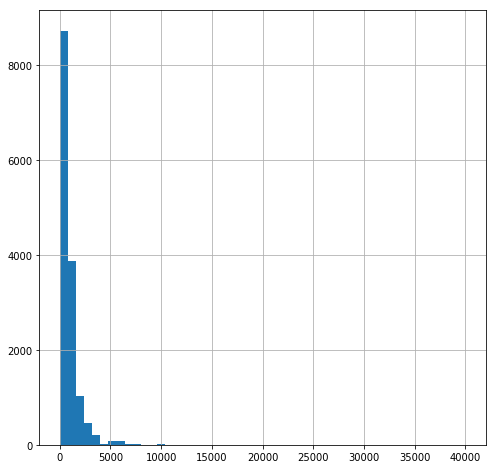

In [37]:
# (단위 999 = 9.99 US Dollar편의상 USD로 표기) 대부분의 가격이 50 USD이하 에 편향 되어 있다.
train_data['price'].hist(bins=50,figsize=(8,8))
plt.show()

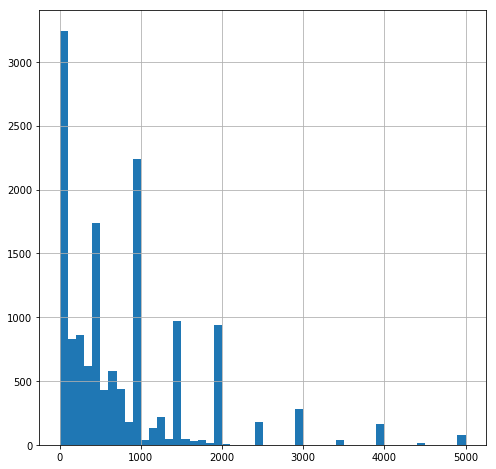

In [38]:
# (free ~ 50.00USD) 
train_data['price'].hist(bins=50, range=[0, 5000], figsize=(8,8))
plt.show()

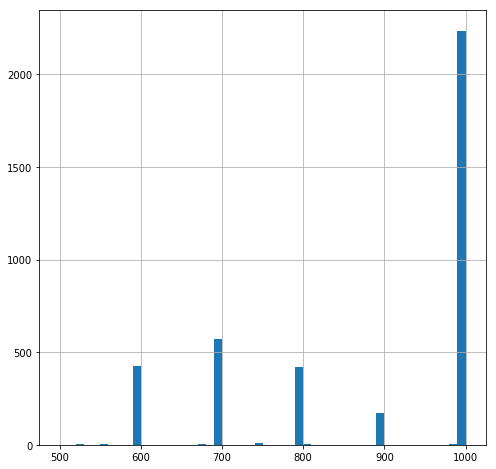

In [39]:
# (5.00 ~ 10.00 USD) 세부적으로 살펴보면 자연수에 -0.01 값이 연산된 가격이 주를 이루는 패턴을 보이고 있다.
# 또한 10.00 USD 많은 게임이 모여 있다.
train_data['price'].hist(bins=50, range=[500, 1000], figsize=(8,8), histtype=('bar'))
plt.show()

In [19]:
# set을 이용한 중복제거 == 카테고리화

publisher_category = list(set(train_data['publisher']))
pb_category['publisher'] = pd.DataFrame(publisher_category)


14722
7176
<class 'list'>
<class 'pandas.core.frame.DataFrame'>


0                            Animation Arts Creative GmbH
1                                              Jaunt Inc.
2                          Game Studio Abraham Stolk Inc.
3                                        Crankshaft Games
4                                        Ranmantaru Games
5                                                   洋葱头科技
6                               App Business Ventures LLC
7                                         Artifice Studio
8                                           SecureMix LLC
9                                           2DragonsGames
10                                             Mystic Box
11                                            Tom Johnson
12      bitComposer Games, Viva Media, Nordic Games, I...
13                                       Other Kind Games
14                                     gnifrebel Games UG
15                                              BindleBot
16                               Warner Bros. Interactive
17            

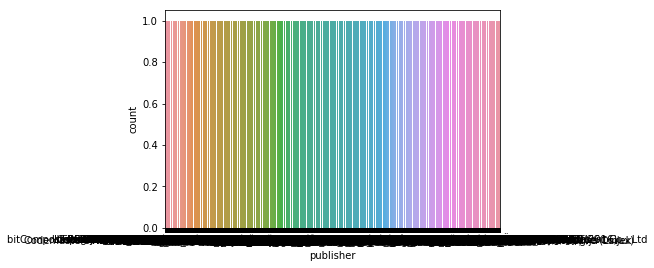

In [22]:
# publisher, developer 따른 countplot를 보려 하였으나 시각적보기에 여건상의 한계가 있음.

sns.countplot(x="publisher", data=pb_category)
plt.show()

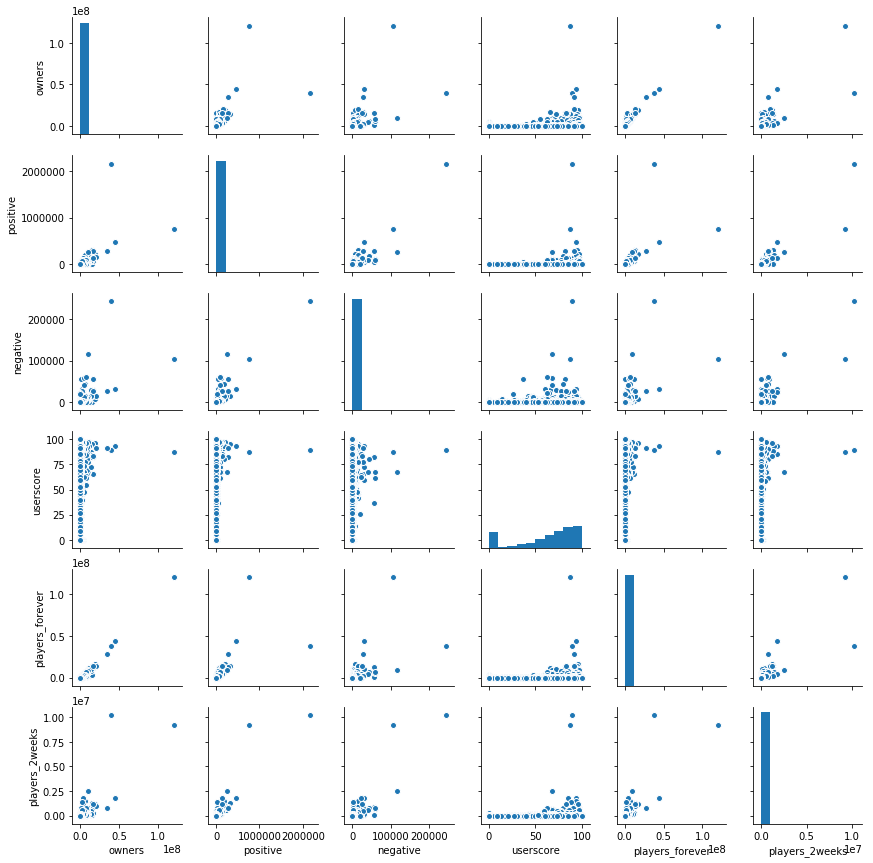

In [12]:
real_data2 = ['owners','positive', 'negative', 'userscore', 'players_forever', 
              'players_2weeks']

sns.pairplot(train_data[real_data2], size=2)

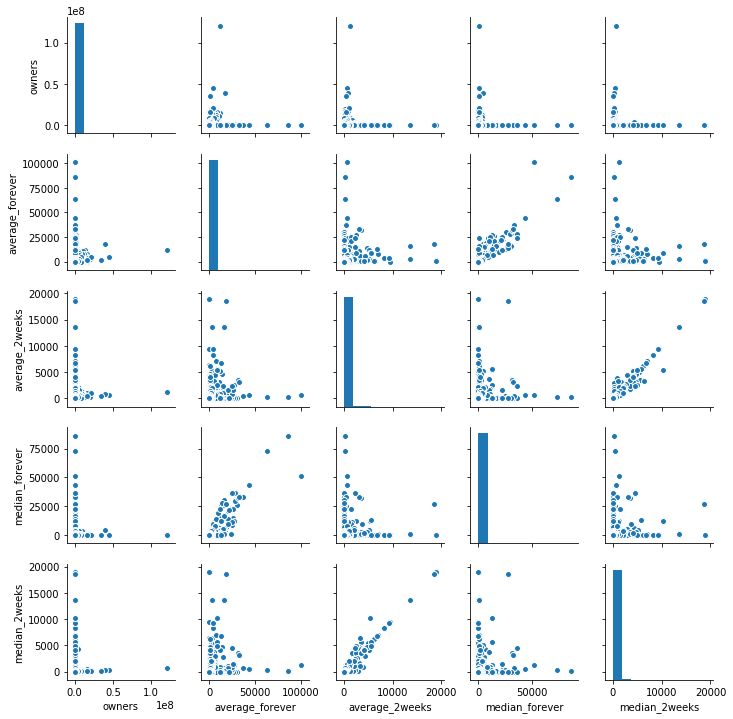

In [55]:
real_data3 = ['owners','average_forever', 'average_2weeks', 
                 'median_forever', 'median_2weeks']

sns.pairplot(train_data[real_data3], size=2)


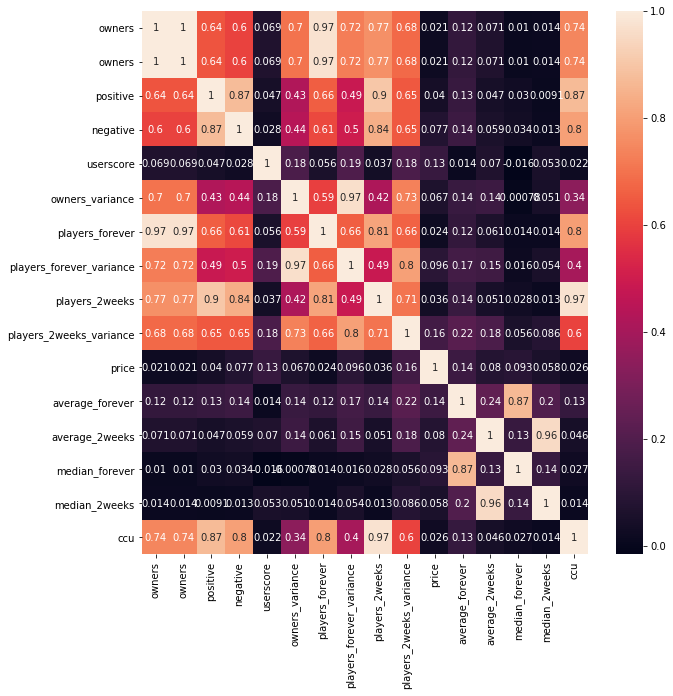

In [57]:
correlation_real_data = pd.concat([train_data['owners'], train_data[real_data]], axis=1)
correlation_real = correlation_real_data.corr()

plt.figure(figsize=(10,10))
sns.heatmap(correlation_real, annot=True)

## 중요변수
price, userscore,average_forever, average_2weeks, median_forever, median_2weeks를 제외한 모든 변수의 상관계수가 0.5 이상을 가르키고 있으므로 중요한 변수로 채택.

In [58]:
select_features = 'positive + negative + owners_variance + players_forever + players_forever_variance + players_2weeks + players_2weeks_variance + ccu'

model1 = sm.OLS.from_formula("owners ~"+select_features, data = train_data)
model1_result = model1.fit()
print(model1_result.summary())

                            OLS Regression Results                            
Dep. Variable:                 owners   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 1.033e+05
Date:                Fri, 26 Jan 2018   Prob (F-statistic):               0.00
Time:                        18:01:27   Log-Likelihood:            -1.9915e+05
No. Observations:               14722   AIC:                         3.983e+05
Df Residuals:                   14713   BIC:                         3.984e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

부족한점:

1. 데이터 전처리
    * 카테고리값(tag, genre 변수 사용못함)을 사용하지 못한상태
    * 카테고리값 VS 카테고리값, 연속(리얼)값 VS 카테고리값 
2. 그로인한 변수간의 다중공선성을 확인불가능
3. 카테고리 값의 부제로 정확한 모델선정에 오류가 있음
4. 리얼변수 만을 이용한 반쪽짜리 모델 
5. 스케일링 필요
6. 정규성 검정
7. 이상치 제거
8. 최적 정규화 여부(가, 부)
9. Cross Validation

Future works <br>
    - 분산분석
    - 사용자 게임 추천 시스템
    - 댓글 자연어 처리 분석 --> positive/ negative 예측